# Preprocessing Billings reservoir data for WQI predicition

## Obtaining data

Data can be obtained at: https://sistemainfoaguas.cetesb.sp.gov.br

### Alto Tietê basin: Billings sub-basin

Sub-basin Points:

| Water Body | City | CETESB Code |
|:---------:|:-----:|:-----------:|
| Reservatório Billings |  São Paulo | BILL 02030|
| Reservatório Billings      |  São Paulo | BILL 02100 |
| Reservatório Billings |  São Bernardo do Campo | BILL 02500 |
| Reservatório Billings      |  São Bernardo do Campo |BILL 02900|
| Braço do Rio Pequeno |  São Bernardo do Campo | BIRP 00500|
| Braço do Ribeirão Taquacetuba     |  São Bernardo do Campo |BITQ 00100|
| Reservatório do Rio Grande |  Ribeirão Pires | RGDE 02030 |
| Reservatório do Rio Grande     |  Ribeirão Pires | RGDE 02200 |
| Reservatório do Rio Grande     |  Ribeirão Pires | RGDE 02900 |

## Example of data matrix for Machine Learning model feeding

| No. | date | DO | BOD | COD | SS | PH | AN | WQI |
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|2|Jan-97|0.0|9.4|32.0|890.0|6.9|9.3|34.3|
|3|Jan-97|0.0|10.6|37.0|250.0|6.6|9.0|39.0|
|4|Jan-97|0.0|6.5|14.0|890.0|7.0|18.5|47.5|
|5|Jan-97|2.1|6.0|38.0|890.0|7.0|9.1|44.4|
|6|Jan-97|2.1|11.3|32.0|890.0|7.1|4.2|41.6|

## Example of data matrix for Machine Learning model feeding
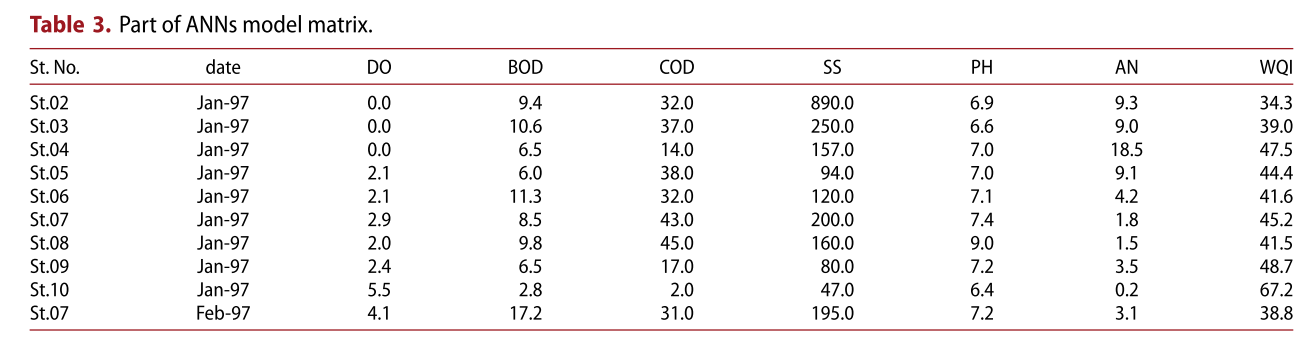

## Preprocessing script

In [8]:
r"""
All imports needed to run code
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import math
from pathlib import PosixPath
from sklearn.impute import SimpleImputer
from scipy import stats

In [9]:
r"""
Appends all excel files into one dataframe
"""

all_files = glob.glob(os.path.join("./data/raw_data", "*.xlsx")) # system path with all excel files

dfs = list() # temporary dataframe

# loop to get all data together within one dataframe
for file in all_files:
  data = pd.read_excel(file, na_values=["NA"])
  #data['arquivo'] = PosixPath(file).stem
  dfs.append(data)

#df_source = pd.concat((pd.read_excel(file, na_values=["NA"]) for file in all_files), ignore_index=True)

df_source = pd.concat(dfs, ignore_index=True) # dataframe with source data

df_source.head() # preview of first 5 lines

,Período DE,Período ATE,Cod_Interaguas,Tipo Rede,UGRHI,Código Ponto,Status Ponto,Data Coleta,Hora Coleta,Parametro,...,CLASSE,Município,UF,Inicio Operação,Fim Operação,Latitude,Longitude,Altitude,Localização,Captação
0,01/01/2015,31/12/2019,141,Rede Básica,06 - ALTO TIÊTE,RGDE02200,Ativo,12/01/2017,13:12,Fluoreto Total,...,Classe 2,RIBEIRAO PIRES,SP,01/01/1983,NaN,23 44 14,46 26 46,746,"No Clube Prainha Tahiti Camping Náutica, na al...",N
1,01/01/2015,31/12/2019,141,Rede Básica,06 - ALTO TIÊTE,RGDE02200,Ativo,09/02/2017,12:15,Fluoreto Total,...,Classe 2,RIBEIRAO PIRES,SP,01/01/1983,NaN,23 44 14,46 26 46,746,"No Clube Prainha Tahiti Camping Náutica, na al...",N
2,01/01/2015,31/12/2019,141,Rede Básica,06 - ALTO TIÊTE,RGDE02200,Ativo,08/03/2017,10:41,Fluoreto Total,...,Classe 2,RIBEIRAO PIRES,SP,01/01/1983,NaN,23 44 14,46 26 46,746,"No Clube Prainha Tahiti Camping Náutica, na al...",N
3,01/01/2015,31/12/2019,141,Rede Básica,06 - ALTO TIÊTE,RGDE02200,Ativo,05/04/2017,12:49,Fluoreto Total,...,Classe 2,RIBEIRAO PIRES,SP,01/01/1983,NaN,23 44 14,46 26 46,746,"No Clube Prainha Tahiti Camping Náutica, na al...",N
4,01/01/2015,31/12/2019,141,Rede Básica,06 - ALTO TIÊTE,RGDE02200,Ativo,04/05/2017,12:46,Fluoreto Total,...,Classe 2,RIBEIRAO PIRES,SP,01/01/1983,NaN,23 44 14,46 26 46,746,"No Clube Prainha Tahiti Camping Náutica, na al...",N


In [10]:
df_source.info() # some info about the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28630 entries, 0 to 28629
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Período DE               28630 non-null  object 
 1   Período ATE              28630 non-null  object 
 2   Cod_Interaguas           28630 non-null  int64  
 3   Tipo Rede                28630 non-null  object 
 4   UGRHI                    28630 non-null  object 
 5   Código Ponto             28630 non-null  object 
 6   Status Ponto             28630 non-null  object 
 7   Data Coleta              28630 non-null  object 
 8   Hora Coleta              28630 non-null  object 
 9   Parametro                28630 non-null  object 
 10  Sinal                    10599 non-null  object 
 11  Valor                    28630 non-null  object 
 12  Unidade                  28630 non-null  object 
 13  Tipo Parâmetro           28630 non-null  object 
 14  Sistema Hídrico       

In [11]:
# Pivots the 'Parametro' column lines in order for each parameter to be a column

df_source.pivot_table(values='Valor', index=['Código Ponto', 'Data Coleta'], columns='Parametro', aggfunc='first')

Parametro                1,1,1 - Tricloroetano 1,1,1,2 - Tetracloroetano  \
Código Ponto Data Coleta                                                   
BILL02030    02/06/2015                    NaN                       NaN   
             02/07/2015                    NaN                       NaN   
             02/10/2019                    NaN                       NaN   
             03/01/2013                    NaN                       NaN   
             04/11/2010                    NaN                       NaN   
...                                        ...                       ...   
RGDE02900    28/11/2012                    NaN                       NaN   
             29/07/2010                    NaN                       NaN   
             29/09/2011                    NaN                       NaN   
             29/11/2018                    NaN                       NaN   
             31/07/2014                    NaN                       NaN   

Parametro                1,1,2 - Tricloroetano 1,1,2,2 - Tetracloroetano  \
Código Ponto Data Coleta                                                   
BILL02030    02/06/2015                    NaN                       NaN   
             02/07/2015                    NaN                       NaN   
             02/10/2019                    NaN                       NaN   
             03/01/2013                    NaN                       NaN   
             04/11/2010                    NaN                       NaN   
...                                        ...                       ...   
RGDE02900    28/11/2012                    NaN                       NaN   
             29/07/2010                    NaN                       NaN   
             29/09/2011                    NaN                       NaN   
             29/11/2018                    NaN                       NaN   
             31/07/2014                    NaN                       NaN   

Parametro                1,1-Dicloro-1-Propeno 1,1-Dicloroetano  \
Código Ponto Data Coleta                                          
BILL02030    02/06/2015                    NaN              NaN   
             02/07/2015                    NaN              NaN   
             02/10/2019                    NaN              NaN   
             03/01/2013                    NaN              NaN   
             04/11/2010                    NaN              NaN   
...                                        ...              ...   
RGDE02900    28/11/2012                    NaN              NaN   
             29/07/2010                    NaN              NaN   
             29/09/2011                    NaN              NaN   
             29/11/2018                    NaN              NaN   
             31/07/2014                    NaN              NaN   

Parametro                1,1-Dicloroeteno 1,2 Dicloroetano  \
Código Ponto Data Coleta                                     
BILL02030    02/06/2015               NaN              NaN   
             02/07/2015               NaN              NaN   
             02/10/2019               NaN              NaN   
             03/01/2013               NaN              NaN   
             04/11/2010               NaN              NaN   
...                                   ...              ...   
RGDE02900    28/11/2012               NaN              NaN   
             29/07/2010               NaN              NaN   
             29/09/2011               NaN              NaN   
             29/11/2018               NaN              NaN   
             31/07/2014               NaN              NaN   

Parametro                1,2,3-Triclorobenzeno 1,2,3-Tricloropropano  ...  \
Código Ponto Data Coleta                                              ...   
BILL02030    02/06/2015                    NaN                   NaN  ...   
             02/07/2015                    NaN                   NaN  ...   
             02/10/2019            

In [12]:
# Block of code to transform dataset into ABT (Analytics Base Table)

# List of dataset columns
new_columns = ['Código Ponto', 'Data Coleta', 'Hora Coleta', 'pH', 'Temperatura da Água', 'Temperatura do Ar', 'Alumínio Dissolvido', 'Cobre Dissolvido', 'Vanádio Total', 'Estireno', 'm,p-Xileno', 'o-Xileno', 'Sólidos Sedimentáveis', 'Manganês Dissolvido', 'Cor Aparente', 'Condutividade', 'Turbidez', 'Boro Total', 'Óleos e Graxas', 'Fenóis Totais', 'Cianeto Livre', 'Tolueno', 'Etilbenzeno', 'Nitrogênio Kjeldahl', 'Nitrogênio-Nitrito', 'Nitrogênio-Nitrato', 'Nitrogênio Amoniacal', 'Nitrogênio Total', 'Oxigênio Dissolvido', 'DBO (5, 20)', 'DQO', 'Fluoreto Total', 'Sólido Dissolvido Total', 'Sólido Total', 'Alumínio Total', 'Fósforo-Ortofosfato', 'Fósforo Total', 'Sulfato Total', 'Sulfeto Total', 'Cloreto Total', 'Crômio Total', 'Crômio Hexavalente', 'Manganês Total', 'Ferro Total', 'Ferro Dissolvido', 'Níquel Total', 'Cobre Total', 'Zinco Total', 'Arsênio Total', 'Selênio Total', 'Ens. Ecotoxic. C/ Ceriodaphnia dubia', 'TA98 - S9', 'TA98 + S9', 'TA100 - S9', 'TA100 + S9', 'Coliformes Termotolerantes', 'Microcistinas', 'Prata Total', 'Cádmio Total', 'Estanho Total', 'Antimônio', 'Bário Total', 'Mercúrio Total', 'Chumbo Total', 'Urânio Total', 'Coloração', 'Chuvas nas últimas 24h', 'Lítio Total', 'Cobalto Total', 'Benzeno', 'Berílio Total', 'Clorofila-a', 'Feofitina-a', 'Ens. Ecotoxic. c/ Vibrio fischeri', 'Transparência', 'Número de Células de Cianobactérias', 'Escherichia coli**', 'Fósforo-Ortofosfato']
df = df_source.pivot_table(values='Valor', index=['Código Ponto', 'Data Coleta', 'Hora Coleta'], columns='Parametro', aggfunc='first')

In [13]:
# Clean unnecessary columns

df_param = df
for column in df_param.columns.values:
  if column not in new_columns:
    df_param.drop(column, axis=1, inplace=True)

df_param

Parametro                            Alumínio Dissolvido Alumínio Total  \
Código Ponto Data Coleta Hora Coleta                                      
BILL02030    02/06/2015  10:27                0,10000000     0,21000000   
             02/07/2015  10:29                0,10000000     0,17000000   
             02/10/2019  12:06                       NaN            NaN   
             03/01/2013  12:03                0,10000000     0,32000000   
             04/11/2010  11:50                0,10000000     0,10000000   
...                                                  ...            ...   
RGDE02900    28/11/2012  10:55                0,10000000     0,10000000   
             29/07/2010  12:38                0,10000000     0,10000000   
             29/09/2011  10:20                       NaN            NaN   
             29/11/2018  13:41                0,11000000     0,19000000   
             31/07/2014  09:40                0,10000000     0,18000000   

Parametro                              Antimônio Arsênio Total     Benzeno  \
Código Ponto Data Coleta Hora Coleta                                         
BILL02030    02/06/2015  10:27               NaN    0,01000000         NaN   
             02/07/2015  10:29               NaN    0,01000000         NaN   
             02/10/2019  12:06               NaN           NaN         NaN   
             03/01/2013  12:03               NaN           NaN         NaN   
             04/11/2010  11:50        0,00200000    0,00200000  2,50000000   
...                                          ...           ...         ...   
RGDE02900    28/11/2012  10:55               NaN           NaN         NaN   
             29/07/2010  12:38               NaN    0,00300000         NaN   
             29/09/2011  10:20               NaN           NaN         NaN   
             29/11/2018  13:41               NaN    0,01000000         NaN   
             31/07/2014  09:40               NaN    0,01000000         NaN   

Parametro                            Berílio Total  Boro Total Bário Total  \
Código Ponto Data Coleta Hora Coleta                                         
BILL02030    02/06/2015  10:27                 NaN         NaN  0,03000000   
             02/07/2015  10:29                 NaN         NaN  0,02000000   
             02/10/2019  12:06                 NaN         NaN         NaN   
             03/01/2013  12:03                 NaN         NaN  0,04000000   
             04/11/2010  11:50          0,00500000  0,03000000  0,02000000   
...                                            ...         ...         ...   
RGDE02900    28/11/2012  10:55                 NaN         NaN  0,02000000   
             29/07/2010  12:38                 NaN         NaN         NaN   
             29/09/2011  10:20                 NaN         NaN         NaN   
             29/11/2018  13:41                 NaN         NaN  0,01000000   
             31/07/2014  09:40                 NaN         NaN  0,02000000   

Parametro                            Chumbo Total Chuvas nas últimas 24h  ...  \
Código Ponto Data Coleta Hora Coleta                                      ...   
BILL02030    02/06/2015  10:27         0,00900000                    Sim  ...   
             02/07/2015  10:29         0,00900000                    Sim  ...   
             02/10/2019  12:06                NaN                    Não  ...   
             03/01/2013  12:03         0,00900000                    Sim  ...   
             04/11/2010  11:50         0,00200000                    Não  ...   
...                                           ...                    ...  ...   
RGDE02900    28/11/2012  10:55         0,00900000                    Sim  ...   
             29/07/2010  12:38         0,00200000                    Não  ...   
             29/09/2011  10:20                NaN                    Não  ...   
             29/11/2018  13:41         0,00700000                    Não  ...   
             31/07/201

In [14]:
# Functions to calculate dissolved oxygen saturation (uses air temperature)

def saturated_DO_concentration(temperature, altitude):
  """
  First step to calculate saturated DO
  Receives the temperature and altitude of the water body
  Returns the concentration of DO saturation
  """
  return (14.62-0.3898*temperature+0.006969*pow(temperature, 2)-0.00005896*pow(temperature, 3))*pow(1-0.0000228675*altitude, 5.167)


def DO_percentage(DO, temperature, altitude):
  """
  Receives DO and the concentration of DO saturation
  Return percentage of DO saturation
  """
  return (100*DO)/saturated_DO_concentration(temperature, altitude)

In [15]:
"""
Function to calculate quality value (q_i) of nth parameter (between 0 and 100) obtained from the respective "average curve of quality variation"
in function of the parameter concentration
"""

def q_i_coliforms(coliforms):
  log_value = math.log10(coliforms)
  if(log_value<=0):
    return 100
  elif(log_value>=0 and log_value<=1):
    return 100-33.5*log_value
  elif(log_value>1 and log_value<=5):
    return 100-37.2*log_value+3.60743*math.pow(log_value, 2)
  elif(log_value>5):
    return 3

def q_i_pH(ph):
  if(ph>0.0 and ph<=2.0):
    return 2
  elif(ph>2.0 and ph<=4.0):
    return 13.6-10.64*ph+2.4364*pow(ph, 2)
  elif(ph>4.0 and ph<=6.2):
    return 155.5-77.36*ph+10.2481*pow(ph, 2)
  elif(ph>6.2 and ph<=7.0):
    return -657.2+197.38*ph-12.9167*pow(ph, 2)
  elif(ph>7.0 and ph<=8.0):
    return -427.8+142.05*ph-9.695*pow(ph, 2)
  elif(ph>8.0 and ph<=8.5):
    return 216-16*ph
  elif(ph>8.5 and ph<=9.0):
    return 1415823*math.exp(-1.1507*ph)
  elif(ph>9.0 and ph<=10.0):
    return 288-27*ph
  elif(ph>10.0 and ph<=12.0):
    return 633-106.5*ph+4.5*pow(ph, 2)
  elif(ph>12.0 and ph<=14.0):
    return 3

def q_i_DBO(dbo):
  if(dbo>0 and dbo<=5):
    return 99.96*math.exp(-0.1232728*dbo)
  elif(dbo>5 and dbo<=15):
    return 104.67-31.5463*math.log(dbo)
  elif(dbo>15 and dbo<=30):
    return 4394.91*math.pow(dbo, -1.99809)
  elif(dbo>30):
    return 2

def q_i_nitrogen(nitrogen):
  if(nitrogen>0 and nitrogen<=10):
    return 100-8.169*nitrogen+0.3059*math.pow(nitrogen, 2)
  elif(nitrogen>10 and nitrogen<=60):
    return 101.9-23.1023*math.log(nitrogen)
  elif(nitrogen>60 and nitrogen<=100):
    return 159.3148*math.exp(-0.0512842*nitrogen)
  elif(nitrogen>100):
    return 1

def q_i_phosphorus(phosphorus):
  phosphate = phosphorus*3.066 # Adjust to phosphate
  if(phosphate>0 and phosphate<=1):
    return 99.9*math.exp(-0.91629*phosphate)
  elif(phosphate>1 and phosphate<=5):
    return 57.6-20.178*phosphate+2.1326*math.pow(phosphate, 2)
  elif(phosphate>5 and phosphate<=10):
    return 19.08*math.exp(-0.13544*phosphate)
  elif(phosphate>10):
    return 5

def q_i_temperature():
  return 94

def q_i_turbidity(turbidity):
  if(turbidity>0 and turbidity<=25):
    return 100.17-2.67*turbidity+0.03775*math.pow(turbidity, 2)
  elif(turbidity>25 and turbidity<=100):
    return 84.96*math.exp(-0.016206*turbidity)
  elif(turbidity>100):
    return 5

def q_i_total_residue(residue):
  if(residue>0 and residue<=150):
    return 79.75+0.166*residue-0.001088*math.pow(residue, 2)
  elif(residue>150 and residue<=500):
    return 101.67-0.13917*residue
  elif(residue>500):
    return 32

def q_i_dissolved_oxigen_saturation_percentage(do, temperature, code_point):
  """
  Altitudes of the points
  BILL02030 = 745m
  BILL02100 = 743m
  BILL02500 = 743m
  BILL02900 = 740m
  BIRP00500 = 743m
  BITQ00100 = 744m
  RGDE02030 = 745m
  RGDE02200 = 744m
  RGDE02900 = 745m
  """
  if(code_point == 'BILL02030'):
    altitude = 745
  elif(code_point == 'BILL02100'):
    altitude = 743
  elif(code_point == 'BILL02500'):
    altitude = 743
  elif(code_point == 'BILL02900'):
    altitude = 740
  elif(code_point == 'BIRP00500'):
    altitude = 743
  elif(code_point == 'BITQ00100'):
    altitude = 744
  elif(code_point == 'RGDE02030'):
    altitude = 745
  elif(code_point == 'RGDE02200'):
    altitude = 744
  elif(code_point == 'RGDE02900'):
    altitude = 745

  do_percentage = DO_percentage(do, temperature, altitude)

  if(do_percentage>0 and do_percentage<=50):
    return 3+0.34*do_percentage+0.008095*math.pow(do_percentage, 2)+1.35252*0.00001*math.pow(do_percentage, 3)
  elif(do_percentage>50 and do_percentage<=85):
    return 3-1.166*do_percentage+0.058*math.pow(do_percentage, 2)-3.803435*0.0001*math.pow(do_percentage, 3)
  elif(do_percentage>85 and do_percentage<=100):
    return 3+3.7745*math.pow(do_percentage, 0.704889)
  elif(do_percentage>100 and do_percentage<=140):
    return 3+2.9*do_percentage-0.02496*math.pow(do_percentage, 2)+5.60919*0.00001*math.pow(do_percentage, 3)
  elif(do_percentage>140):
    return 3+47

In [16]:
"""
Filter columns needed for WQI prediction
"""

df_wqi = df_param.loc[:,['Coliformes Termotolerantes', 'Escherichia coli**', 'pH', 'DBO (5, 20)', 'Nitrogênio Kjeldahl', 'Nitrogênio-Nitrito', 'Nitrogênio-Nitrato', 'Nitrogênio Amoniacal', 'Nitrogênio Total', 'Fósforo Total', 'Temperatura da Água', 'Turbidez', 'Sólido Total', 'Oxigênio Dissolvido']]

df_wqi

Parametro                            Coliformes Termotolerantes  \
Código Ponto Data Coleta Hora Coleta                              
BILL02030    02/06/2015  10:27                              NaN   
             02/07/2015  10:29                              NaN   
             02/10/2019  12:06                              NaN   
             03/01/2013  12:03                              NaN   
             04/11/2010  11:50                     320,00000000   
...                                                         ...   
RGDE02900    28/11/2012  10:55                              NaN   
             29/07/2010  12:38                     140,00000000   
             29/09/2011  10:20                     108,00000000   
             29/11/2018  13:41                              NaN   
             31/07/2014  09:40                              NaN   

Parametro                            Escherichia coli**          pH  \
Código Ponto Data Coleta Hora Coleta                                  
BILL02030    02/06/2015  10:27              61,00000000  7,01000000   
             02/07/2015  10:29             180,00000000  7,56000000   
             02/10/2019  12:06             256,00000000  8,84000000   
             03/01/2013  12:03             840,00000000  7,87000000   
             04/11/2010  11:50                      NaN  8,90000000   
...                                                 ...         ...   
RGDE02900    28/11/2012  10:55              50,00000000  7,47000000   
             29/07/2010  12:38                      NaN  8,10000000   
             29/09/2011  10:20                      NaN  8,60000000   
             29/11/2018  13:41               1,00000000  9,37000000   
             31/07/2014  09:40               1,00000000  6,90000000   

Parametro                             DBO (5, 20) Nitrogênio Kjeldahl  \
Código Ponto Data Coleta Hora Coleta                                    
BILL02030    02/06/2015  10:27         6,00000000          0,89000000   
             02/07/2015  10:29         3,00000000          1,65000000   
             02/10/2019  12:06         9,00000000          6,82000000   
             03/01/2013  12:03        11,00000000          3,33000000   
             04/11/2010  11:50        17,00000000          3,67000000   
...                                           ...                 ...   
RGDE02900    28/11/2012  10:55         3,00000000          0,80000000   
             29/07/2010  12:38         3,00000000          0,50000000   
             29/09/2011  10:20         4,00000000          0,94000000   
             29/11/2018  13:41         3,00000000                 NaN   
             31/07/2014  09:40         3,00000000          1,14000000   

Parametro                            Nitrogênio-Nitrito Nitrogênio-Nitrato  \
Código Ponto Data Coleta Hora Coleta                                         
BILL02030    02/06/2015  10:27               0,10000000         1,96000000   
             02/07/2015  10:29               0,12000000         1,28000000   
             02/10/2019  12:06               0,10000000         0,77000000   
             03/01/2013  12:03               0,12000000         0,20000000   
             04/11/2010  11:50               1,34000000         0,53000000   
...                                                 ...                ...   
RGDE02900    28/11/2012  10:55               0,01000000         0,20000000   
             29/07/2010  12:38               0,26000000         0,21000000   
             29/09/2011  10:20               0,02000000         0,29000000   
             29/11/2018  13:41               0,10000000         0,20000000   
             31/07/2014  09:40               0,10000000         0,52000000   

Parametro                            Nitrogênio Amoniacal Nitrogênio Total  \
Código Ponto Data Coleta Hora Coleta                                         
BILL02030    02/06/2015  10:27                 0,28000000              NaN   
     

In [17]:
# Format data

df_wqi = df_wqi.replace(regex={',': '.'}).astype(float) # Replace ',' into '.' and converts object data type into float

df_wqi.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 617 entries, ('BILL02030', '02/06/2015', '10:27') to ('RGDE02900', '31/07/2014', '09:40')
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Coliformes Termotolerantes  84 non-null     float64
 1   Escherichia coli**          530 non-null    float64
 2   pH                          614 non-null    float64
 3   DBO (5, 20)                 614 non-null    float64
 4   Nitrogênio Kjeldahl         341 non-null    float64
 5   Nitrogênio-Nitrito          613 non-null    float64
 6   Nitrogênio-Nitrato          613 non-null    float64
 7   Nitrogênio Amoniacal        614 non-null    float64
 8   Nitrogênio Total            273 non-null    float64
 9   Fósforo Total               613 non-null    float64
 10  Temperatura da Água         614 non-null    float64
 11  Turbidez                    608 non-null    float64
 12  Sólido Total            

In [18]:
# Drop Null rows where WQI parameters were not measured

for index, row in df_wqi.iterrows():
  null_row = row.isnull().sum()
  if(null_row == 14):
    remove = index
    df_wqi.drop(remove, inplace=True)

df_wqi.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 614 entries, ('BILL02030', '02/06/2015', '10:27') to ('RGDE02900', '31/07/2014', '09:40')
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Coliformes Termotolerantes  84 non-null     float64
 1   Escherichia coli**          530 non-null    float64
 2   pH                          614 non-null    float64
 3   DBO (5, 20)                 614 non-null    float64
 4   Nitrogênio Kjeldahl         341 non-null    float64
 5   Nitrogênio-Nitrito          613 non-null    float64
 6   Nitrogênio-Nitrato          613 non-null    float64
 7   Nitrogênio Amoniacal        614 non-null    float64
 8   Nitrogênio Total            273 non-null    float64
 9   Fósforo Total               613 non-null    float64
 10  Temperatura da Água         614 non-null    float64
 11  Turbidez                    608 non-null    float64
 12  Sólido Total            

In [19]:
# Consolidate columns that depends of values in other columns

for index, row in df_wqi.iterrows():
  if(pd.isna(row['Coliformes Termotolerantes'])):
    row['Coliformes Termotolerantes'] = 1.25*row['Escherichia coli**']
  if(pd.isna(row['Nitrogênio Total'])):
    row['Nitrogênio Total'] = np.nansum([row['Nitrogênio Kjeldahl'], row['Nitrogênio-Nitrito'], row['Nitrogênio-Nitrato']])

df_wqi.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 614 entries, ('BILL02030', '02/06/2015', '10:27') to ('RGDE02900', '31/07/2014', '09:40')
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Coliformes Termotolerantes  614 non-null    float64
 1   Escherichia coli**          530 non-null    float64
 2   pH                          614 non-null    float64
 3   DBO (5, 20)                 614 non-null    float64
 4   Nitrogênio Kjeldahl         341 non-null    float64
 5   Nitrogênio-Nitrito          613 non-null    float64
 6   Nitrogênio-Nitrato          613 non-null    float64
 7   Nitrogênio Amoniacal        614 non-null    float64
 8   Nitrogênio Total            614 non-null    float64
 9   Fósforo Total               613 non-null    float64
 10  Temperatura da Água         614 non-null    float64
 11  Turbidez                    608 non-null    float64
 12  Sólido Total            

In [20]:
# Drop Null rows where WQI parameters were not measured

for index, row in df_wqi.iterrows():
  null_row = row.isnull().sum()
  if(null_row == 13):
    remove = index
    df_wqi.drop(remove, inplace=True)

df_wqi.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 614 entries, ('BILL02030', '02/06/2015', '10:27') to ('RGDE02900', '31/07/2014', '09:40')
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Coliformes Termotolerantes  614 non-null    float64
 1   Escherichia coli**          530 non-null    float64
 2   pH                          614 non-null    float64
 3   DBO (5, 20)                 614 non-null    float64
 4   Nitrogênio Kjeldahl         341 non-null    float64
 5   Nitrogênio-Nitrito          613 non-null    float64
 6   Nitrogênio-Nitrato          613 non-null    float64
 7   Nitrogênio Amoniacal        614 non-null    float64
 8   Nitrogênio Total            614 non-null    float64
 9   Fósforo Total               613 non-null    float64
 10  Temperatura da Água         614 non-null    float64
 11  Turbidez                    608 non-null    float64
 12  Sólido Total            

In [21]:
# Drop columns not needed anymore after consolidating needed columns

df_wqi.drop(['Escherichia coli**', 'Nitrogênio Kjeldahl', 'Nitrogênio-Nitrito', 'Nitrogênio-Nitrato', 'Nitrogênio Amoniacal'], axis=1, inplace=True)

df_wqi.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 614 entries, ('BILL02030', '02/06/2015', '10:27') to ('RGDE02900', '31/07/2014', '09:40')
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Coliformes Termotolerantes  614 non-null    float64
 1   pH                          614 non-null    float64
 2   DBO (5, 20)                 614 non-null    float64
 3   Nitrogênio Total            614 non-null    float64
 4   Fósforo Total               613 non-null    float64
 5   Temperatura da Água         614 non-null    float64
 6   Turbidez                    608 non-null    float64
 7   Sólido Total                614 non-null    float64
 8   Oxigênio Dissolvido         614 non-null    float64
dtypes: float64(9)
memory usage: 62.1+ KB


In [22]:
# Remove rows containing null values all columns

for index, row in df_wqi.iterrows():
  if(pd.isna(row['Coliformes Termotolerantes']) or pd.isna(row['pH']) or pd.isna(row['DBO (5, 20)']) or pd.isna(row['Nitrogênio Total']) or pd.isna(row['Fósforo Total']) or pd.isna(row['Temperatura da Água']) or pd.isna(row['Turbidez']) or pd.isna(row['Sólido Total']) or pd.isna(row['Oxigênio Dissolvido'])):
    df_wqi.drop([index], axis=0, inplace=True)

df_wqi.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 607 entries, ('BILL02030', '02/06/2015', '10:27') to ('RGDE02900', '31/07/2014', '09:40')
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Coliformes Termotolerantes  607 non-null    float64
 1   pH                          607 non-null    float64
 2   DBO (5, 20)                 607 non-null    float64
 3   Nitrogênio Total            607 non-null    float64
 4   Fósforo Total               607 non-null    float64
 5   Temperatura da Água         607 non-null    float64
 6   Turbidez                    607 non-null    float64
 7   Sólido Total                607 non-null    float64
 8   Oxigênio Dissolvido         607 non-null    float64
dtypes: float64(9)
memory usage: 61.6+ KB


In [23]:
# Calculate quality values

"""q_i is the grade obtained according to the parameter concentration in the water"""
q1 = list() # Fecal coliforms parameter quality
q2 = list() # pH parameter quality
q3 = list() # BOD (Biochemical oxygen demand) parameter quality
q4 = list() # Total nitrogen parameter quality
q5 = list() # Total phosphor parameter quality
q6 = list() # Temperature parameter quality
q7 = list() # Turbidity parameter quality
q8 = list() # Total residue parameter quality
q9 = list() # DO (Dissolved Oxygen) parameter quality

"""
Store (Coliforms) values in a list, either Total Coliforms or applying a correction factor to E. Coli when TC is null
"""
for index, row in df_wqi.iterrows():
  if(pd.notna(row['Coliformes Termotolerantes'])):
    q1.append(row['Coliformes Termotolerantes'])
  else:
    q1.append(row['Escherichia coli**']*1.25)

"""
Store (pH) values in a list
"""
q2 = [value for value in df_wqi['pH']]

"""
Store (DBO) values in a list
"""
q3 = [value for value in df_wqi['DBO (5, 20)']]

"""
Store (Total Nitrogen) values in a list
"""
for index, row in df_wqi.iterrows():
  if(pd.isna(row['Nitrogênio Total'])):
    #q4.append(row['Nitrogênio Total'])
    q4.append(np.nansum([row['Nitrogênio Kjeldahl'], row['Nitrogênio-Nitrito'], row['Nitrogênio-Nitrato']]))
  else:
    q4.append(row['Nitrogênio Total'])

"""
Store (Phosphor) values in a list
"""
q5 = [value for value in df_wqi['Fósforo Total']]

"""
Store (Temperature) values in a list
"""
q6 = [value for value in df_wqi['Temperatura da Água']]

"""
Store (Turbidity) values in a list
"""
q7 = [value for value in df_wqi['Turbidez']]

"""
Store (Total Residue) values in a list
"""
q8 = [value for value in df_wqi['Sólido Total']]

"""
Store (Dissolved Oxigen) values in a list
"""
q9_list = list()
for index, row in df_wqi.iterrows():
  q9_list.append(([row['Oxigênio Dissolvido'], row['Temperatura da Água'], index[0]])) # index[0] = 'Código Ponto' index which gets the value of code point index


"""
Applying quality functions over Parameter values obtaining the respective quality values
"""

q1 = [q_i_coliforms(value) for value in q1]

q2 = [q_i_pH(value) for value in q2]

q3 = [q_i_DBO(value) for value in q3]

q4 = [q_i_nitrogen(value) for value in q4]

q5 = [q_i_phosphorus(value) for value in q5]

q6 = [q_i_temperature() for value in q6]

q7 = [q_i_turbidity(value) for value in q7]

q8 = [q_i_total_residue(value) for value in q8]

for i in range(len(q9_list)):
  dox, temp, code_point = q9_list[i]
  q9.append(q_i_dissolved_oxigen_saturation_percentage(dox, temp, code_point))

In [24]:
# Dataframe with the quality values
quality = {'q1': q1,
           'q2': q2,
           'q3': q3,
           'q4': q4,
           'q5': q5,
           'q6': q6,
           'q7': q7,
           'q8': q8,
           'q9': q9}

df_quality = pd.DataFrame(quality)

df_quality

,q1,q2,q3,q4,q5,q6,q7,q8,q9
0,42.761178,91.557231,48.146618,78.563545,60.249096,94,91.407819,79.681140,40.487984
1,32.457864,91.993848,69.058344,77.930185,60.249096,94,82.289479,78.846120,45.481899
2,29.447845,54.110786,35.355694,55.270123,23.449130,94,5.000000,74.392680,83.559831
3,20.538881,89.655255,29.025276,74.258503,63.552423,94,75.737160,84.188688,12.597427
4,29.447845,50.500920,15.289817,64.132300,52.353579,94,46.796095,81.093232,79.152314
...,...,...,...,...,...,...,...,...,...
602,44.827893,92.323775,69.058344,92.061359,97.954616,94,96.429095,85.470000,87.592104
603,36.779375,86.400000,69.058344,92.363891,82.065321,94,94.981000,85.470000,92.022658
604,39.272682,71.321765,61.049127,90.266719,94.973839,94,87.603460,85.470000,92.022658
605,96.753515,35.010000,69.058344,95.208724,91.825435,94,93.730938,85.470000,86.925445


In [25]:
"""
Calculate WQI values from quality values
"""

w1, w2, w3, w4, w5, w6, w7, w8, w9 = 0.15, 0.12, 0.10, 0.10, 0.10, 0.10, 0.08, 0.08, 0.17 # Respective parameter weights in WQI equation

wqi = list()

for index, row in df_quality.iterrows():
  qw_i = np.prod([math.pow(row['q1'], w1), math.pow(row['q2'], w2), math.pow(row['q3'], w3), math.pow(row['q4'], w4), math.pow(row['q5'], w5), math.pow(row['q6'], w6), math.pow(row['q7'], w7), math.pow(row['q8'], w8), math.pow(row['q9'], w9)])
  wqi.append(qw_i)

WQI = {'WQI': wqi}

df_temp_wqi = pd.DataFrame(WQI)

df_final_wqi = pd.concat([df_quality, df_temp_wqi], ignore_index=False, axis=1)

df_final_wqi

,q1,q2,q3,q4,q5,q6,q7,q8,q9,WQI
0,42.761178,91.557231,48.146618,78.563545,60.249096,94,91.407819,79.681140,40.487984,62.428032
1,32.457864,91.993848,69.058344,77.930185,60.249096,94,82.289479,78.846120,45.481899,62.741024
2,29.447845,54.110786,35.355694,55.270123,23.449130,94,5.000000,74.392680,83.559831,42.087403
3,20.538881,89.655255,29.025276,74.258503,63.552423,94,75.737160,84.188688,12.597427,43.011718
4,29.447845,50.500920,15.289817,64.132300,52.353579,94,46.796095,81.093232,79.152314,50.371354
...,...,...,...,...,...,...,...,...,...,...
602,44.827893,92.323775,69.058344,92.061359,97.954616,94,96.429095,85.470000,87.592104,80.133718
603,36.779375,86.400000,69.058344,92.363891,82.065321,94,94.981000,85.470000,92.022658,76.390796
604,39.272682,71.321765,61.049127,90.266719,94.973839,94,87.603460,85.470000,92.022658,74.903660
605,96.753515,35.010000,69.058344,95.208724,91.825435,94,93.730938,85.470000,86.925445,79.524720


In [26]:
"""
Final dataframe concatenating Raw Data with Quality data and WQI
"""

df_final = pd.concat([df_wqi.reset_index(level=[0, 1, 0]), df_final_wqi], ignore_index=False, axis=1)

df_final

,Código Ponto,Data Coleta,Coliformes Termotolerantes,pH,"DBO (5, 20)",Nitrogênio Total,Fósforo Total,Temperatura da Água,Turbidez,Sólido Total,...,q1,q2,q3,q4,q5,q6,q7,q8,q9,WQI
0,BILL02030,02/06/2015,76.25,7.01,6.0,2.95,0.180,19.81,3.45,158.0,...,42.761178,91.557231,48.146618,78.563545,60.249096,94,91.407819,79.681140,40.487984,62.428032
1,BILL02030,02/07/2015,225.00,7.56,3.0,3.05,0.180,18.62,7.49,164.0,...,32.457864,91.993848,69.058344,77.930185,60.249096,94,82.289479,78.846120,45.481899,62.741024
2,BILL02030,02/10/2019,320.00,8.84,9.0,7.69,0.720,21.30,109.00,196.0,...,29.447845,54.110786,35.355694,55.270123,23.449130,94,5.000000,74.392680,83.559831,42.087403
3,BILL02030,03/01/2013,1050.00,7.87,11.0,3.65,0.161,24.95,10.80,118.0,...,20.538881,89.655255,29.025276,74.258503,63.552423,94,75.737160,84.188688,12.597427,43.011718
4,BILL02030,04/11/2010,320.00,8.90,17.0,5.54,0.230,24.00,36.80,144.0,...,29.447845,50.500920,15.289817,64.132300,52.353579,94,46.796095,81.093232,79.152314,50.371354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,RGDE02900,28/11/2012,62.50,7.47,3.0,1.01,0.007,24.10,1.43,100.0,...,44.827893,92.323775,69.058344,92.061359,97.954616,94,96.429095,85.470000,87.592104,80.133718
603,RGDE02900,29/07/2010,140.00,8.10,3.0,0.97,0.070,20.40,2.00,100.0,...,36.779375,86.400000,69.058344,92.363891,82.065321,94,94.981000,85.470000,92.022658,76.390796
604,RGDE02900,29/09/2011,108.00,8.60,4.0,1.25,0.018,20.40,5.07,100.0,...,39.272682,71.321765,61.049127,90.266719,94.973839,94,87.603460,85.470000,92.022658,74.903660
605,RGDE02900,29/11/2018,1.25,9.37,3.0,0.60,0.030,25.60,2.50,100.0,...,96.753515,35.010000,69.058344,95.208724,91.825435,94,93.730938,85.470000,86.925445,79.524720


In [27]:
# Cast object to date values in 'Data Coleta' column

df_final['Data Coleta'] = pd.to_datetime(df_final['Data Coleta'], format='%d/%m/%Y')

In [28]:
# Sort values by date ('Data Coleta')

df_final = df_final.sort_values('Data Coleta')

df_final.reset_index(drop=True, inplace=True)

df_final

,Código Ponto,Data Coleta,Coliformes Termotolerantes,pH,"DBO (5, 20)",Nitrogênio Total,Fósforo Total,Temperatura da Água,Turbidez,Sólido Total,...,q1,q2,q3,q4,q5,q6,q7,q8,q9,WQI
0,BILL02900,2010-01-28,70.00,7.5,4.00,1.93,0.07,25.9,5.40,112.0,...,43.643440,92.23125,61.049127,85.373277,82.065321,94,86.852790,84.694128,90.792218,76.630444
1,RGDE02200,2010-01-28,740.00,7.2,3.00,1.27,0.04,25.0,4.33,100.0,...,22.962714,92.37120,69.058344,90.118756,89.281641,94,89.316671,85.470000,98.386056,72.648794
2,BILL02100,2010-01-28,400.00,7.2,7.00,2.97,0.05,25.5,5.60,114.0,...,27.628253,92.37120,43.283735,78.436383,86.808316,94,86.401840,84.534352,75.564301,66.791144
3,BITQ00100,2010-01-28,9.00,8.3,5.00,1.86,0.04,26.0,21.70,122.0,...,68.032876,83.20000,53.968800,85.863952,89.281641,94,60.007098,83.808208,88.154226,77.824700
4,BILL02030,2010-01-28,2500.00,7.0,3.00,3.26,0.09,25.6,6.37,104.0,...,15.248005,91.54170,69.058344,76.620043,77.581471,94,84.693878,85.246192,23.743294,51.766023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,BILL02500,2019-12-04,1.25,8.2,3.10,1.29,0.04,24.5,12.60,108.0,...,96.753515,84.80000,68.212268,89.971038,89.281641,94,72.521190,84.987568,93.327908,86.802179
603,BIRP00500,2019-12-04,1.25,7.7,3.00,1.06,0.01,22.6,6.46,100.0,...,96.753515,91.16845,69.058344,91.684569,97.132520,94,84.497168,85.470000,95.854388,90.115264
604,BILL02900,2019-12-04,1.25,8.2,3.00,1.02,0.02,22.6,6.24,100.0,...,96.753515,84.80000,69.058344,91.985878,94.441707,94,84.979094,85.470000,94.722866,88.974960
605,BILL02100,2019-12-04,185.00,7.4,4.30,2.54,0.13,23.1,20.70,162.0,...,34.203646,92.47180,58.832655,81.224284,69.335346,94,61.076498,79.124460,90.685941,69.644568


In [29]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Código Ponto                607 non-null    object        
 1   Data Coleta                 607 non-null    datetime64[ns]
 2   Coliformes Termotolerantes  607 non-null    float64       
 3   pH                          607 non-null    float64       
 4   DBO (5, 20)                 607 non-null    float64       
 5   Nitrogênio Total            607 non-null    float64       
 6   Fósforo Total               607 non-null    float64       
 7   Temperatura da Água         607 non-null    float64       
 8   Turbidez                    607 non-null    float64       
 9   Sólido Total                607 non-null    float64       
 10  Oxigênio Dissolvido         607 non-null    float64       
 11  q1                          607 non-null    float64       

In [30]:
df_final.to_excel("data/processed/tabela_completa.xlsx")
df_final.to_csv("data/processed/tabela_completa.csv")

In [31]:
df_final.to_excel("data/processed/tabela_valores_qualidade.xlsx")
df_final_wqi.to_csv("data/processed/tabela_valores_qualidade.csv")